# Code to generate Figure 4

In [1]:
#import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from utils.svm import LinearSupportVectorMachine_noOffset
from utils.RandFourier import RandomFourier
from utils.functions import * 

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

import matplotlib
import matplotlib.pyplot as plt

figwidth = 8
figheight = 4

## Load and preprocess the data

In [2]:
# Load Dataset
X, Y, labels = load_wdbc()

# Creat Train and Test sets
X_train, X_test, ytrain, ytest = train_test_split(X, Y, test_size=0.3, random_state=1)
y_train = np.asarray(ytrain)
y_test = np.asarray(ytest)

# Preprocess
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Find a prototype for each class

In [3]:
# prototype[0]: class 1
# prototype[1]: class -1

prototype = [np.mean(X_train_scaled[y_train == 1], axis=0), np.mean(X_train_scaled[y_train == -1], axis=0)]


## Setting the parameters

`F`: number of features for the RBF feature map approximation  
`noise_lambda`: noise scale


In [4]:
n = X_train_scaled.shape[0] # number of training data points
C = np.sqrt(n) # SVM parameter should scale as such (consistent classifier)
print("C:",C)

# number of features (should be an even number)
F = int(2*50) 

beta = 5

# calculate noise scale: lambda 
noise_lambda = 4*C*np.sqrt(F)/(beta*n)
print("noise scale lambda:",noise_lambda)
print("privacy beta:",beta)

C: 19.949937343260004
noise scale lambda: 0.4010037656936684
privacy beta: 5


## Random Fourier Features: RBF kernel approximation

In [5]:
FM_transform = RandomFourier(n_components=F, random_state=1).fit(X_train_scaled)
X_train_FM = FM_transform.transform(X_train_scaled)
X_test_FM = FM_transform.transform(X_test_scaled)


## Train SVM Classifier

In [6]:
SVM = LinearSupportVectorMachine_noOffset(C=C)
lagr_multipliers, idx_support_vectors, support_vectors, support_vector_labels = SVM.fit(X_train_FM, y_train)

# weight vector
w = np.dot(lagr_multipliers*support_vector_labels,support_vectors)

evaluation = np.sign(SVM.predict(X_test_FM).flatten()) == y_test
print("Classification accuracy:", sum(evaluation)/len(evaluation))


Classification accuracy: 0.9239766081871345


## Generate Laplace noise

In [7]:
np.random.seed(seed=1)
mu = np.random.laplace(loc=0.0, scale=noise_lambda, size=(1,F))

evaluation_privacy = np.sign(SVM.predict(X_test_FM, mu).flatten()) == y_test
print("Classification accuracy:", sum(evaluation_privacy)/len(evaluation_privacy))


Classification accuracy: 0.8771929824561403


## Check if prototypes are correctly classified

In [8]:
prototype_prediction = np.sign(SVM.predict(FM_transform.transform(prototype), noise=mu))
check = prototype_prediction.flatten() == [1,-1]
if np.all(check):
    print("Correct prototypes' predictions!")
else:
    print("Misclassification of prototype",check)


Correct prototypes' predictions!


## Select a test data instance whose classification we want to explain and select the prototype of different class

In [9]:
#np.random.seed(seed=1)
#idx_selected = np.random.randint(0,len(X_test))
idx_selected = 30
instance = X_test_scaled[idx_selected]
instance_transformed = FM_transform.transform(instance.reshape(1, -1))

prediction_instance = np.sign(SVM.predict(instance_transformed, noise=mu).flatten())
print("Index of selected test data:", idx_selected, "-- Predicted class:", prediction_instance, "-- True class label:", y_test[idx_selected])

# choose prototype of different class than instance
selected_prototype = prototype[np.where(prediction_instance != [1,-1])[0][0]]
selected_prototype_transformed = FM_transform.transform(selected_prototype.reshape(1, -1))


Index of selected test data: 30 -- Predicted class: [1.] -- True class label: 1


## Counterfactual Explanation

In [10]:
proba = 0.9

# Bisection
explanation, plot_convergence = bisection_chance(instance, prediction_instance, selected_prototype, SVM, FM_transform, mu, noise_lambda, p=proba, acc=0.0001)


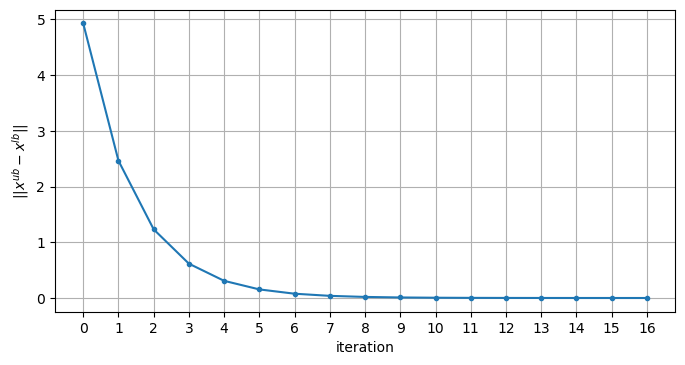

In [11]:
# plot convergence
fig, ax = plt.subplots(figsize=[figwidth, figheight], dpi=100)
ax.plot(np.absolute(plot_convergence), c="tab:blue", marker=".")
ax.set(xlabel="iteration", ylabel="$||{x}^{ub} - {x}^{lb}||$", title='')
ax.grid()
plt.xticks(np.arange(0, 17, 1.0))
plt.show()

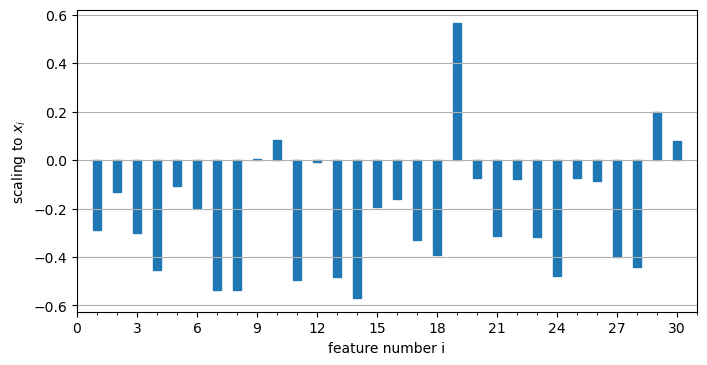

In [12]:
# Plot Explanation unscaled
x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots(figsize=[figwidth, figheight], dpi=100)
ax.bar(x+1 , (unscale(explanation,scaler)-unscale(instance,scaler))/unscale(instance,scaler) , width, edgecolor='tab:blue', color="tab:blue")

ax.set_xlim((0,31))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.xaxis.set_major_locator(MultipleLocator(3))
ax.set(xlabel="feature number i", ylabel="scaling to $x_i$", title='')
ax.grid(axis="y")
plt.show()